# 实验3论文实验复现 (Lab3 Implement)

Author: 高鹏昺

Email: nbgao@126.com


**复现论文**

[An Analysis of Single Layer Networks in Unsupervised Feature Learning](https://ai.stanford.edu/~ang/papers/nipsdlufl10-AnalysisSingleLayerUnsupervisedFeatureLearning.pdf)


**核心参数**

* 数据集大小: data_num = 5000
* 单张图像采样块数: M = 10
* 采样块/感受野宽度: W = 6
* 感受野滑动步长: S = 1
* 聚类中心数: K = 500

In [1]:
import numpy as np
import sklearn
import scipy.io as sio
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from skimage import feature as feature
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import random
import time
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# mnist = fetch_mldata('mnist-original', data_home = './data/') 
mnist = sio.loadmat('./data/mnist-original.mat')
mnist

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar 30 03:19:02 2014',
 '__version__': '1.0',
 '__globals__': [],
 'mldata_descr_ordering': array([[array(['label'], dtype='<U5'), array(['data'], dtype='<U4')]],
       dtype=object),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'label': array([[0., 0., 0., ..., 9., 9., 9.]])}

In [3]:
data, label = mnist['data'].T, mnist['label'].T.astype('int')

print('data shape:', data.shape)
print('label shape:', label.shape)

data shape: (70000, 784)
label shape: (70000, 1)


In [21]:
index_list = range(data.shape[0])
random_index = random.sample(index_list, 5000)

In [22]:
data = data[random_index]
label = label[random_index]
print(data.shape)
print(label.shape)

(5000, 784)
(5000, 1)


In [23]:
data_num, feature_num = data.shape
print('data_num:', data_num)
print('feature_num:', feature_num)

data_num: 5000
feature_num: 784


## Parameters

In [24]:
M = 10  # 每个图像随机采样的patch数
K = 500  # 聚类的中心数(特征数)
W = 6  # 采样patch的宽度
S = 1  # 感受野滑动步长

# 1. 特征学习阶段 Feature Learning

## 1.1 Sampling

In [28]:
# 随机采样切块函数
def Sampling(img, w):
    x = np.random.randint(28-w+1)
    y = np.random.randint(28-w+1)
    patch = img[x:x+w, y:y+w]
    return patch

In [29]:
patch_list = np.zeros((data_num*M, W, W))
k = 0
time_start = time.time()
# 对所有训练图像进行分块取样
for i in range(data_num):
    # 每张图像取样M次
    for j in range(M):
        # 分块采样,patch大小为w*w
        img = data[i].reshape(28,28)
        patch = Sampling(img, W)
        patch_list[k] = patch
        k += 1
           
time_end = time.time()
print('Patch Sampling time: {:.1f}s'.format(time_end-time_start))

Patch Sampling time: 0.2s


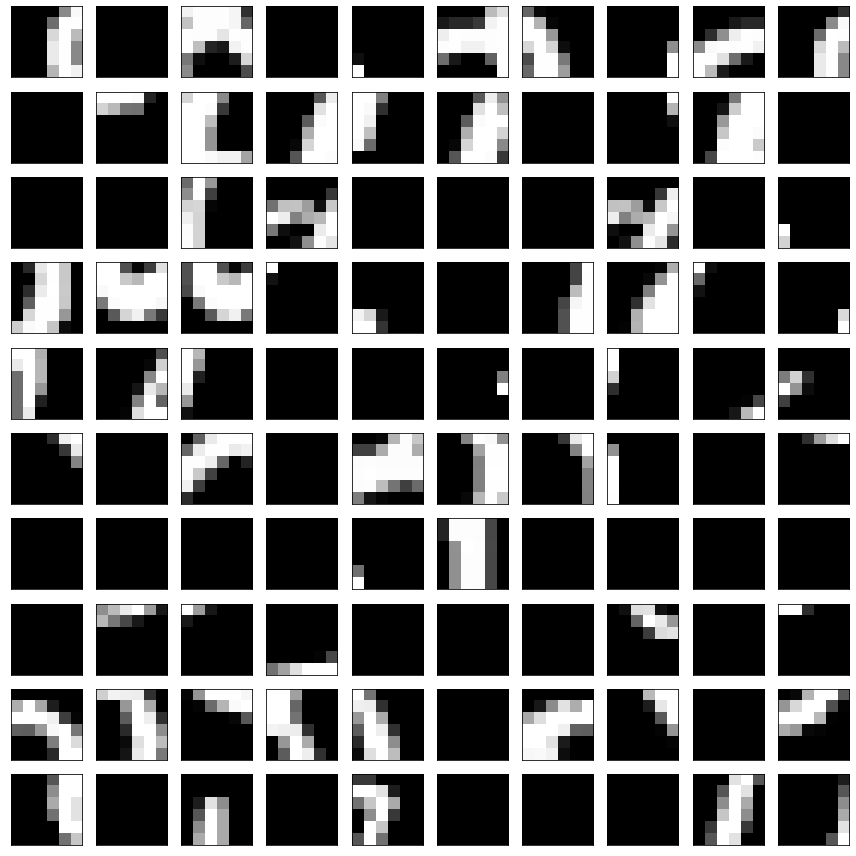

In [30]:
# 随机选取100个patch图显示
patch_num = patch_list.shape[0]
patch_index = random.sample(range(patch_num), 100)
plt.figure(figsize=(12,12))
k = 0
for i in range(1,11):
    for j in range(1,11):
        ax = plt.subplot(10,10,k+1)
        plt.imshow(patch_list[k], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        k += 1
        
plt.tight_layout()

## 1.2 Pre-processing

### 1.2.1 Normalization (Standardization)
#### 采用的是z-score标准化

In [31]:
def Standardization(X):
    u = X.mean()
    s = X.std()
    return (X-u)/(s+1e-6)

In [32]:
time_start = time.time()
patch_ss = patch_list.copy()
for i in range(patch_num):
    patch_ss[i] = Standardization(patch_ss[i])
    
time_end = time.time()
print('Normalization time: {:.1f}s'.format(time_end-time_start))

Normalization time: 1.4s


In [33]:
patch_ss[100]

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

### 1.2.2 PCA Whitening

In [34]:
def PCA_whitening(X):
    # 减去均值，使得以0为中心
    X -= np.mean(X)
    # 计算协方差矩阵
    cov = np.dot(X.T, X) / X.shape[0]
    # 协方差矩阵奇异值分解SVD
    U,S,V = np.linalg.svd(cov)
    X_rot = np.dot(X, U) 
    X_white = X_rot / np.sqrt(S + 1e-6)
    return X

In [35]:
time_start = time.time()
patch_wh = patch_ss.copy()
for i in range(patch_num):
    patch_wh[i] = PCA_whitening(patch_wh[i])
    
time_end = time.time()
print('PCA-Whitening time: {:.1f}s'.format(time_end-time_start))

PCA-Whitening time: 2.4s


In [36]:
patch_wh[100]

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

#### ZCA-Whitening

In [37]:
def zca_whitening(inputs):
    sigma = np.dot(inputs, inputs.T)/inputs.shape[1] #inputs是经过归一化处理的，所以这边就相当于计算协方差矩阵
    U,S,V = np.linalg.svd(sigma) #奇异分解
    epsilon = 0.1                #白化的时候，防止除数为0
    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(np.diag(S) + epsilon))), U.T)                     #计算zca白化矩阵
    return np.dot(ZCAMatrix, inputs)   #白化变换

## 1.3 Unsupervised Learning - K-Means

In [38]:
from sklearn.cluster import KMeans

time_start = time.time()
# 将patch_wh的最后一维展平
patch_wh_flatten = patch_wh.reshape(patch_num, -1)
# K = 1000
kmeans = KMeans(n_clusters=K, random_state=0)
kmeans.fit(patch_wh_flatten)

time_end = time.time()
print('K-Means time: {:.1f}s'.format(time_end-time_start))

K-Means time: 148.2s


In [39]:
# 无监督学习到的K个中心
C = kmeans.cluster_centers_
C.shape

(500, 36)

### Visualization
### 可视化学习到的中心(centroids)

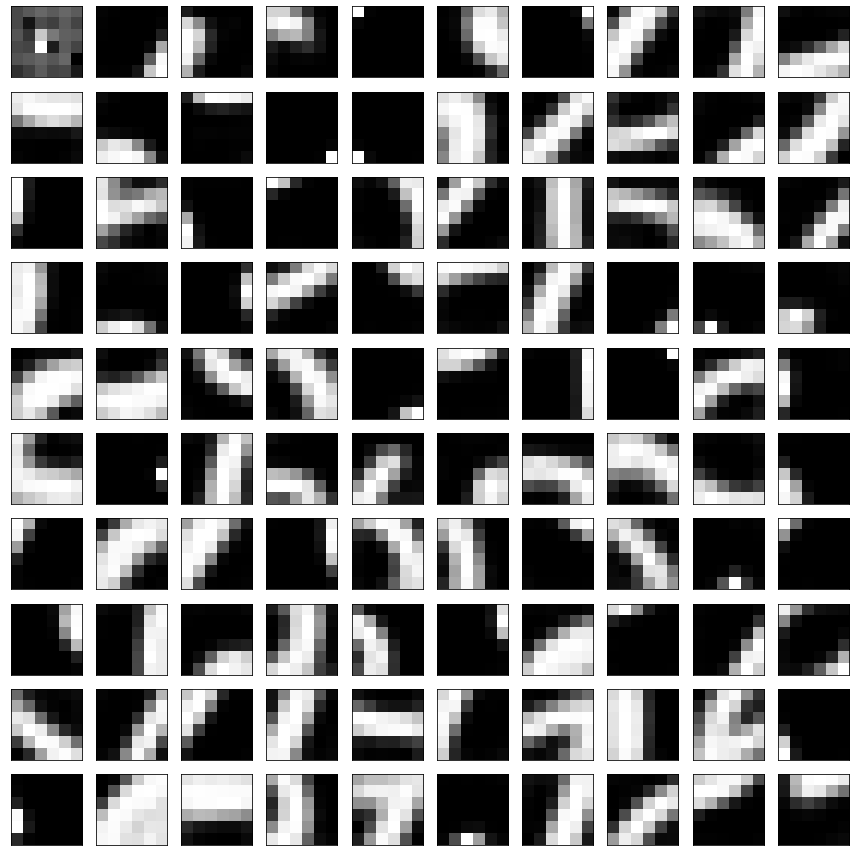

In [40]:
# 随机选取100个中心特征图显示
centroid_index = random.sample(range(K), 100)
plt.figure(figsize=(12,12))
k = 0
for i in range(1,11):
    for j in range(1,11):
        ax = plt.subplot(10,10,k+1)
        img = C[k].reshape(6,6)
        plt.imshow(img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        k += 1
        
plt.tight_layout()

# 2. Feature Extraction 

## 2.1 Convolutional Extraction


In [41]:
def dist(x, c):
    return np.sum(np.square(x-c))

In [42]:
time_start = time.time()

# 扫描后窗口大小
sn = 28-W+1
f = np.zeros((data_num,2,2,K))
feature = np.zeros((data_num,4*K))
for i in range(data_num):
    time1 = time.time()
    img = data[i].reshape(28,28)
    # 23 * 23 * 1600
    y = np.zeros((sn, sn, K))
    # 感受野滑动
    for sx in range(sn):
        for sy in range(sn):
            patch = img[sx:sx+W, sy:sy+W]
            D = np.zeros(K)
            for k in range(K):
                patch_flatten = patch.reshape(W*W)
                D[k] = dist(patch_flatten, C[k])
            min_c = np.argmin(D)
            # 最接近的中心类下标置1
            y[sx][sy][min_c] = 1
            
    # 4象限平均池化 23*23 -> 2*2
    for k in range(K):
        f[i][0][0][k] = np.mean(y[:sn//2, :sn//2, k])
        f[i][0][1][k] = np.mean(y[:sn//2, sn//2:, k])
        f[i][1][0][k] = np.mean(y[sn//2:, :sn//2, k])
        f[i][1][1][k] = np.mean(y[sn//2:, sn//2:, k])
    
    # 最后一维拼接
    feature[i] = f[i].reshape(4*K)
    time2 = time.time()
    print('Step: {:d}, time: {:.2f}s'.format(i, time2-time1))

time_end = time.time()
print('Feature Extraction time: {:.1f}s'.format(time_end-time_start))

Step: 0, time: 1.97s
Step: 1, time: 1.83s
Step: 2, time: 1.80s
Step: 3, time: 1.87s
Step: 4, time: 1.82s
Step: 5, time: 1.86s
Step: 6, time: 1.85s
Step: 7, time: 1.83s
Step: 8, time: 1.77s
Step: 9, time: 1.85s
Step: 10, time: 1.85s
Step: 11, time: 1.86s
Step: 12, time: 1.85s
Step: 13, time: 1.88s
Step: 14, time: 1.85s
Step: 15, time: 1.86s
Step: 16, time: 1.86s
Step: 17, time: 1.90s
Step: 18, time: 1.84s
Step: 19, time: 1.86s
Step: 20, time: 1.85s
Step: 21, time: 1.84s
Step: 22, time: 1.85s
Step: 23, time: 1.86s
Step: 24, time: 1.85s
Step: 25, time: 1.86s
Step: 26, time: 1.85s
Step: 27, time: 1.88s
Step: 28, time: 1.86s
Step: 29, time: 1.84s
Step: 30, time: 1.85s
Step: 31, time: 1.86s
Step: 32, time: 1.86s
Step: 33, time: 1.86s
Step: 34, time: 1.83s
Step: 35, time: 1.86s
Step: 36, time: 1.85s
Step: 37, time: 1.86s
Step: 38, time: 1.85s
Step: 39, time: 1.85s
Step: 40, time: 1.84s
Step: 41, time: 1.88s
Step: 42, time: 1.85s
Step: 43, time: 1.87s
Step: 44, time: 1.85s
Step: 45, time: 1.86

Step: 361, time: 1.76s
Step: 362, time: 1.76s
Step: 363, time: 1.78s
Step: 364, time: 1.79s
Step: 365, time: 1.78s
Step: 366, time: 1.82s
Step: 367, time: 1.78s
Step: 368, time: 1.87s
Step: 369, time: 1.85s
Step: 370, time: 1.84s
Step: 371, time: 1.80s
Step: 372, time: 1.81s
Step: 373, time: 1.81s
Step: 374, time: 1.81s
Step: 375, time: 1.79s
Step: 376, time: 1.80s
Step: 377, time: 1.80s
Step: 378, time: 1.81s
Step: 379, time: 1.80s
Step: 380, time: 1.78s
Step: 381, time: 1.80s
Step: 382, time: 1.78s
Step: 383, time: 1.80s
Step: 384, time: 1.79s
Step: 385, time: 1.80s
Step: 386, time: 1.78s
Step: 387, time: 1.81s
Step: 388, time: 1.80s
Step: 389, time: 1.79s
Step: 390, time: 1.79s
Step: 391, time: 1.78s
Step: 392, time: 1.80s
Step: 393, time: 1.87s
Step: 394, time: 1.86s
Step: 395, time: 1.79s
Step: 396, time: 1.79s
Step: 397, time: 1.83s
Step: 398, time: 1.82s
Step: 399, time: 1.78s
Step: 400, time: 1.81s
Step: 401, time: 1.81s
Step: 402, time: 1.82s
Step: 403, time: 1.82s
Step: 404, 

Step: 718, time: 1.78s
Step: 719, time: 1.77s
Step: 720, time: 1.79s
Step: 721, time: 1.76s
Step: 722, time: 1.77s
Step: 723, time: 1.75s
Step: 724, time: 1.75s
Step: 725, time: 1.75s
Step: 726, time: 1.76s
Step: 727, time: 1.76s
Step: 728, time: 1.80s
Step: 729, time: 1.76s
Step: 730, time: 1.76s
Step: 731, time: 1.76s
Step: 732, time: 1.74s
Step: 733, time: 1.80s
Step: 734, time: 1.78s
Step: 735, time: 1.79s
Step: 736, time: 1.79s
Step: 737, time: 1.78s
Step: 738, time: 1.81s
Step: 739, time: 1.80s
Step: 740, time: 1.73s
Step: 741, time: 1.79s
Step: 742, time: 1.81s
Step: 743, time: 1.77s
Step: 744, time: 1.84s
Step: 745, time: 1.81s
Step: 746, time: 1.82s
Step: 747, time: 1.76s
Step: 748, time: 1.88s
Step: 749, time: 1.80s
Step: 750, time: 1.79s
Step: 751, time: 1.78s
Step: 752, time: 1.77s
Step: 753, time: 1.75s
Step: 754, time: 1.76s
Step: 755, time: 1.79s
Step: 756, time: 1.79s
Step: 757, time: 1.81s
Step: 758, time: 1.75s
Step: 759, time: 1.79s
Step: 760, time: 1.80s
Step: 761, 

Step: 1072, time: 1.82s
Step: 1073, time: 1.77s
Step: 1074, time: 1.77s
Step: 1075, time: 1.80s
Step: 1076, time: 1.81s
Step: 1077, time: 1.83s
Step: 1078, time: 1.78s
Step: 1079, time: 1.78s
Step: 1080, time: 1.76s
Step: 1081, time: 1.76s
Step: 1082, time: 1.77s
Step: 1083, time: 1.81s
Step: 1084, time: 1.78s
Step: 1085, time: 1.79s
Step: 1086, time: 1.79s
Step: 1087, time: 1.86s
Step: 1088, time: 1.85s
Step: 1089, time: 1.82s
Step: 1090, time: 1.88s
Step: 1091, time: 1.89s
Step: 1092, time: 1.88s
Step: 1093, time: 1.84s
Step: 1094, time: 1.83s
Step: 1095, time: 1.84s
Step: 1096, time: 1.85s
Step: 1097, time: 1.79s
Step: 1098, time: 1.79s
Step: 1099, time: 1.84s
Step: 1100, time: 1.82s
Step: 1101, time: 1.86s
Step: 1102, time: 1.78s
Step: 1103, time: 1.77s
Step: 1104, time: 1.83s
Step: 1105, time: 1.74s
Step: 1106, time: 1.79s
Step: 1107, time: 1.78s
Step: 1108, time: 1.73s
Step: 1109, time: 1.79s
Step: 1110, time: 1.78s
Step: 1111, time: 1.80s
Step: 1112, time: 1.76s
Step: 1113, time

Step: 1414, time: 2.21s
Step: 1415, time: 1.98s
Step: 1416, time: 2.00s
Step: 1417, time: 2.01s
Step: 1418, time: 1.99s
Step: 1419, time: 1.94s
Step: 1420, time: 2.00s
Step: 1421, time: 1.95s
Step: 1422, time: 2.01s
Step: 1423, time: 1.96s
Step: 1424, time: 1.98s
Step: 1425, time: 1.98s
Step: 1426, time: 1.98s
Step: 1427, time: 1.97s
Step: 1428, time: 1.98s
Step: 1429, time: 1.98s
Step: 1430, time: 2.11s
Step: 1431, time: 2.14s
Step: 1432, time: 2.11s
Step: 1433, time: 2.13s
Step: 1434, time: 2.13s
Step: 1435, time: 2.19s
Step: 1436, time: 2.13s
Step: 1437, time: 2.04s
Step: 1438, time: 2.01s
Step: 1439, time: 2.19s
Step: 1440, time: 2.21s
Step: 1441, time: 2.27s
Step: 1442, time: 2.14s
Step: 1443, time: 2.08s
Step: 1444, time: 1.96s
Step: 1445, time: 1.94s
Step: 1446, time: 1.94s
Step: 1447, time: 1.97s
Step: 1448, time: 1.95s
Step: 1449, time: 1.97s
Step: 1450, time: 4.34s
Step: 1451, time: 4.77s
Step: 1452, time: 4.62s
Step: 1453, time: 2.51s
Step: 1454, time: 1.95s
Step: 1455, time

Step: 1756, time: 1.77s
Step: 1757, time: 1.76s
Step: 1758, time: 1.79s
Step: 1759, time: 1.76s
Step: 1760, time: 1.78s
Step: 1761, time: 1.75s
Step: 1762, time: 1.74s
Step: 1763, time: 1.74s
Step: 1764, time: 1.74s
Step: 1765, time: 1.74s
Step: 1766, time: 1.74s
Step: 1767, time: 1.73s
Step: 1768, time: 1.72s
Step: 1769, time: 1.73s
Step: 1770, time: 1.74s
Step: 1771, time: 1.77s
Step: 1772, time: 1.75s
Step: 1773, time: 1.79s
Step: 1774, time: 1.74s
Step: 1775, time: 1.77s
Step: 1776, time: 1.78s
Step: 1777, time: 1.75s
Step: 1778, time: 1.78s
Step: 1779, time: 1.76s
Step: 1780, time: 1.77s
Step: 1781, time: 1.82s
Step: 1782, time: 1.81s
Step: 1783, time: 1.78s
Step: 1784, time: 1.76s
Step: 1785, time: 1.76s
Step: 1786, time: 1.78s
Step: 1787, time: 1.78s
Step: 1788, time: 1.75s
Step: 1789, time: 1.78s
Step: 1790, time: 1.77s
Step: 1791, time: 1.75s
Step: 1792, time: 1.81s
Step: 1793, time: 1.77s
Step: 1794, time: 1.75s
Step: 1795, time: 1.77s
Step: 1796, time: 1.78s
Step: 1797, time

Step: 2098, time: 1.77s
Step: 2099, time: 1.76s
Step: 2100, time: 1.77s
Step: 2101, time: 1.78s
Step: 2102, time: 1.80s
Step: 2103, time: 1.78s
Step: 2104, time: 1.79s
Step: 2105, time: 1.79s
Step: 2106, time: 1.78s
Step: 2107, time: 1.79s
Step: 2108, time: 1.79s
Step: 2109, time: 1.81s
Step: 2110, time: 1.78s
Step: 2111, time: 3.48s
Step: 2112, time: 3.83s
Step: 2113, time: 1.76s
Step: 2114, time: 1.75s
Step: 2115, time: 1.80s
Step: 2116, time: 1.76s
Step: 2117, time: 1.77s
Step: 2118, time: 1.77s
Step: 2119, time: 1.79s
Step: 2120, time: 1.78s
Step: 2121, time: 1.75s
Step: 2122, time: 1.75s
Step: 2123, time: 1.76s
Step: 2124, time: 1.77s
Step: 2125, time: 1.77s
Step: 2126, time: 1.77s
Step: 2127, time: 1.76s
Step: 2128, time: 1.76s
Step: 2129, time: 1.76s
Step: 2130, time: 1.74s
Step: 2131, time: 1.76s
Step: 2132, time: 1.78s
Step: 2133, time: 1.76s
Step: 2134, time: 1.77s
Step: 2135, time: 1.79s
Step: 2136, time: 1.77s
Step: 2137, time: 1.77s
Step: 2138, time: 1.78s
Step: 2139, time

Step: 2440, time: 1.80s
Step: 2441, time: 2.11s
Step: 2442, time: 2.32s
Step: 2443, time: 2.07s
Step: 2444, time: 2.18s
Step: 2445, time: 1.98s
Step: 2446, time: 2.09s
Step: 2447, time: 2.24s
Step: 2448, time: 1.96s
Step: 2449, time: 1.99s
Step: 2450, time: 1.98s
Step: 2451, time: 1.97s
Step: 2452, time: 2.13s
Step: 2453, time: 1.99s
Step: 2454, time: 1.96s
Step: 2455, time: 1.98s
Step: 2456, time: 2.11s
Step: 2457, time: 2.14s
Step: 2458, time: 2.13s
Step: 2459, time: 2.07s
Step: 2460, time: 2.23s
Step: 2461, time: 2.25s
Step: 2462, time: 2.46s
Step: 2463, time: 2.89s
Step: 2464, time: 2.32s
Step: 2465, time: 2.13s
Step: 2466, time: 2.13s
Step: 2467, time: 2.13s
Step: 2468, time: 2.06s
Step: 2469, time: 1.99s
Step: 2470, time: 2.06s
Step: 2471, time: 2.16s
Step: 2472, time: 2.05s
Step: 2473, time: 2.04s
Step: 2474, time: 2.20s
Step: 2475, time: 2.09s
Step: 2476, time: 2.10s
Step: 2477, time: 1.97s
Step: 2478, time: 1.97s
Step: 2479, time: 2.06s
Step: 2480, time: 2.05s
Step: 2481, time

Step: 2782, time: 1.88s
Step: 2783, time: 1.86s
Step: 2784, time: 1.85s
Step: 2785, time: 1.86s
Step: 2786, time: 1.87s
Step: 2787, time: 1.87s
Step: 2788, time: 1.86s
Step: 2789, time: 1.87s
Step: 2790, time: 1.85s
Step: 2791, time: 1.84s
Step: 2792, time: 1.84s
Step: 2793, time: 1.83s
Step: 2794, time: 1.79s
Step: 2795, time: 1.84s
Step: 2796, time: 1.82s
Step: 2797, time: 1.83s
Step: 2798, time: 1.83s
Step: 2799, time: 1.80s
Step: 2800, time: 4.01s
Step: 2801, time: 2.27s
Step: 2802, time: 1.78s
Step: 2803, time: 1.79s
Step: 2804, time: 1.79s
Step: 2805, time: 1.79s
Step: 2806, time: 1.78s
Step: 2807, time: 1.79s
Step: 2808, time: 1.79s
Step: 2809, time: 1.79s
Step: 2810, time: 1.78s
Step: 2811, time: 1.86s
Step: 2812, time: 1.86s
Step: 2813, time: 1.87s
Step: 2814, time: 1.86s
Step: 2815, time: 1.87s
Step: 2816, time: 1.88s
Step: 2817, time: 1.87s
Step: 2818, time: 1.92s
Step: 2819, time: 1.89s
Step: 2820, time: 1.92s
Step: 2821, time: 1.91s
Step: 2822, time: 1.85s
Step: 2823, time

Step: 3124, time: 1.94s
Step: 3125, time: 1.92s
Step: 3126, time: 1.92s
Step: 3127, time: 1.94s
Step: 3128, time: 1.96s
Step: 3129, time: 2.00s
Step: 3130, time: 2.01s
Step: 3131, time: 1.98s
Step: 3132, time: 1.98s
Step: 3133, time: 1.99s
Step: 3134, time: 1.97s
Step: 3135, time: 1.99s
Step: 3136, time: 1.94s
Step: 3137, time: 1.96s
Step: 3138, time: 1.91s
Step: 3139, time: 1.94s
Step: 3140, time: 1.85s
Step: 3141, time: 1.85s
Step: 3142, time: 1.80s
Step: 3143, time: 1.84s
Step: 3144, time: 1.82s
Step: 3145, time: 1.83s
Step: 3146, time: 1.86s
Step: 3147, time: 1.85s
Step: 3148, time: 1.82s
Step: 3149, time: 1.90s
Step: 3150, time: 1.84s
Step: 3151, time: 1.81s
Step: 3152, time: 1.92s
Step: 3153, time: 1.85s
Step: 3154, time: 1.83s
Step: 3155, time: 1.84s
Step: 3156, time: 1.89s
Step: 3157, time: 1.94s
Step: 3158, time: 1.91s
Step: 3159, time: 1.87s
Step: 3160, time: 1.86s
Step: 3161, time: 1.82s
Step: 3162, time: 1.81s
Step: 3163, time: 1.84s
Step: 3164, time: 1.86s
Step: 3165, time

Step: 3466, time: 1.91s
Step: 3467, time: 1.91s
Step: 3468, time: 1.94s
Step: 3469, time: 1.91s
Step: 3470, time: 1.83s
Step: 3471, time: 1.90s
Step: 3472, time: 1.96s
Step: 3473, time: 1.90s
Step: 3474, time: 1.88s
Step: 3475, time: 1.87s
Step: 3476, time: 1.93s
Step: 3477, time: 1.88s
Step: 3478, time: 1.91s
Step: 3479, time: 1.83s
Step: 3480, time: 1.87s
Step: 3481, time: 1.89s
Step: 3482, time: 1.86s
Step: 3483, time: 2.12s
Step: 3484, time: 1.86s
Step: 3485, time: 1.88s
Step: 3486, time: 1.90s
Step: 3487, time: 1.99s
Step: 3488, time: 1.93s
Step: 3489, time: 1.93s
Step: 3490, time: 1.98s
Step: 3491, time: 1.87s
Step: 3492, time: 1.91s
Step: 3493, time: 1.90s
Step: 3494, time: 1.95s
Step: 3495, time: 1.86s
Step: 3496, time: 1.91s
Step: 3497, time: 1.83s
Step: 3498, time: 1.84s
Step: 3499, time: 1.84s
Step: 3500, time: 1.90s
Step: 3501, time: 1.87s
Step: 3502, time: 1.86s
Step: 3503, time: 1.83s
Step: 3504, time: 1.82s
Step: 3505, time: 1.81s
Step: 3506, time: 1.79s
Step: 3507, time

Step: 3808, time: 1.85s
Step: 3809, time: 1.82s
Step: 3810, time: 1.88s
Step: 3811, time: 1.93s
Step: 3812, time: 1.87s
Step: 3813, time: 1.98s
Step: 3814, time: 1.95s
Step: 3815, time: 1.85s
Step: 3816, time: 1.85s
Step: 3817, time: 1.84s
Step: 3818, time: 1.90s
Step: 3819, time: 1.84s
Step: 3820, time: 1.87s
Step: 3821, time: 1.86s
Step: 3822, time: 1.84s
Step: 3823, time: 1.86s
Step: 3824, time: 1.82s
Step: 3825, time: 1.85s
Step: 3826, time: 1.85s
Step: 3827, time: 1.84s
Step: 3828, time: 1.84s
Step: 3829, time: 1.82s
Step: 3830, time: 1.82s
Step: 3831, time: 3.22s
Step: 3832, time: 3.39s
Step: 3833, time: 1.99s
Step: 3834, time: 1.80s
Step: 3835, time: 1.83s
Step: 3836, time: 1.84s
Step: 3837, time: 1.81s
Step: 3838, time: 3.09s
Step: 3839, time: 3.33s
Step: 3840, time: 3.00s
Step: 3841, time: 1.90s
Step: 3842, time: 1.88s
Step: 3843, time: 1.87s
Step: 3844, time: 1.87s
Step: 3845, time: 1.86s
Step: 3846, time: 1.86s
Step: 3847, time: 1.86s
Step: 3848, time: 1.85s
Step: 3849, time

Step: 4150, time: 1.87s
Step: 4151, time: 3.95s
Step: 4152, time: 4.21s
Step: 4153, time: 4.21s
Step: 4154, time: 4.24s
Step: 4155, time: 2.62s
Step: 4156, time: 1.86s
Step: 4157, time: 1.87s
Step: 4158, time: 1.86s
Step: 4159, time: 1.83s
Step: 4160, time: 1.86s
Step: 4161, time: 1.85s
Step: 4162, time: 1.86s
Step: 4163, time: 1.83s
Step: 4164, time: 1.83s
Step: 4165, time: 1.84s
Step: 4166, time: 1.87s
Step: 4167, time: 1.87s
Step: 4168, time: 1.84s
Step: 4169, time: 1.90s
Step: 4170, time: 1.84s
Step: 4171, time: 1.86s
Step: 4172, time: 1.86s
Step: 4173, time: 1.85s
Step: 4174, time: 1.85s
Step: 4175, time: 1.93s
Step: 4176, time: 1.84s
Step: 4177, time: 1.94s
Step: 4178, time: 1.89s
Step: 4179, time: 1.90s
Step: 4180, time: 1.86s
Step: 4181, time: 1.85s
Step: 4182, time: 1.91s
Step: 4183, time: 1.92s
Step: 4184, time: 1.95s
Step: 4185, time: 1.92s
Step: 4186, time: 1.90s
Step: 4187, time: 1.99s
Step: 4188, time: 1.94s
Step: 4189, time: 1.98s
Step: 4190, time: 1.89s
Step: 4191, time

Step: 4492, time: 2.01s
Step: 4493, time: 1.94s
Step: 4494, time: 1.95s
Step: 4495, time: 1.98s
Step: 4496, time: 1.90s
Step: 4497, time: 1.88s
Step: 4498, time: 1.92s
Step: 4499, time: 1.92s
Step: 4500, time: 1.90s
Step: 4501, time: 3.79s
Step: 4502, time: 2.47s
Step: 4503, time: 1.88s
Step: 4504, time: 1.93s
Step: 4505, time: 1.84s
Step: 4506, time: 1.86s
Step: 4507, time: 1.87s
Step: 4508, time: 1.84s
Step: 4509, time: 1.82s
Step: 4510, time: 1.86s
Step: 4511, time: 1.87s
Step: 4512, time: 1.83s
Step: 4513, time: 1.88s
Step: 4514, time: 1.87s
Step: 4515, time: 1.87s
Step: 4516, time: 1.81s
Step: 4517, time: 1.83s
Step: 4518, time: 1.81s
Step: 4519, time: 1.83s
Step: 4520, time: 1.83s
Step: 4521, time: 1.85s
Step: 4522, time: 1.83s
Step: 4523, time: 1.79s
Step: 4524, time: 1.82s
Step: 4525, time: 1.83s
Step: 4526, time: 1.82s
Step: 4527, time: 1.85s
Step: 4528, time: 1.82s
Step: 4529, time: 1.84s
Step: 4530, time: 1.85s
Step: 4531, time: 1.83s
Step: 4532, time: 1.90s
Step: 4533, time

Step: 4834, time: 1.89s
Step: 4835, time: 1.87s
Step: 4836, time: 1.87s
Step: 4837, time: 1.88s
Step: 4838, time: 1.87s
Step: 4839, time: 1.89s
Step: 4840, time: 1.88s
Step: 4841, time: 1.90s
Step: 4842, time: 1.93s
Step: 4843, time: 1.93s
Step: 4844, time: 1.92s
Step: 4845, time: 1.94s
Step: 4846, time: 1.88s
Step: 4847, time: 2.01s
Step: 4848, time: 2.02s
Step: 4849, time: 1.99s
Step: 4850, time: 1.94s
Step: 4851, time: 1.96s
Step: 4852, time: 1.92s
Step: 4853, time: 1.92s
Step: 4854, time: 1.92s
Step: 4855, time: 1.94s
Step: 4856, time: 1.92s
Step: 4857, time: 1.94s
Step: 4858, time: 1.93s
Step: 4859, time: 1.93s
Step: 4860, time: 1.92s
Step: 4861, time: 2.01s
Step: 4862, time: 1.96s
Step: 4863, time: 2.07s
Step: 4864, time: 1.88s
Step: 4865, time: 1.88s
Step: 4866, time: 1.93s
Step: 4867, time: 2.01s
Step: 4868, time: 3.63s
Step: 4869, time: 4.22s
Step: 4870, time: 4.15s
Step: 4871, time: 4.24s
Step: 4872, time: 4.20s
Step: 4873, time: 4.09s
Step: 4874, time: 3.40s
Step: 4875, time

In [31]:
feature.shape

(1000, 4000)

In [43]:
# 保存特征
np.save('./data/feature_2.npy', feature)
# feature = np.load('./data/feature_1.npy')

# 3. Classification
使用LinearSVM L2作为分类器模型进行训练和预测

### Split Dataset

In [128]:
feature_train, feature_test, label_train, label_test = train_test_split(feature, label, test_size=1/10)
print('feature_train.shape:', feature_train.shape)
print('feature_test.shape:', feature_test.shape)

feature_train.shape: (4500, 2000)
feature_test.shape: (500, 2000)


### Train

In [129]:
from sklearn.svm import LinearSVC
# svc = SVC()
svc_l2 = LinearSVC(penalty='l2')
svc_l2.fit(feature_train, label_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

### Test

In [130]:
label_predict = svc_l2.predict(feature_test)

In [131]:
# 单次数据切分正确率
print('The Accuracy of Linear SVM:', svc_l2.score(feature_test, label_test))
print(classification_report(label_test, label_predict))

The Accuracy of Linear SVM: 0.942
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        44
           1       0.95      1.00      0.97        75
           2       1.00      0.98      0.99        50
           3       0.97      0.95      0.96        60
           4       0.86      0.97      0.91        37
           5       0.92      0.94      0.93        49
           6       0.98      0.96      0.97        45
           7       0.96      0.88      0.92        50
           8       0.94      0.88      0.91        51
           9       0.90      0.90      0.90        39

    accuracy                           0.94       500
   macro avg       0.94      0.94      0.94       500
weighted avg       0.94      0.94      0.94       500



### K-Fold Cross Validation (K折交叉验证)

In [127]:
from sklearn.model_selection import cross_val_score

svc_l2 = LinearSVC(penalty='l2')

# K折交叉验证(K=10)
scores = cross_val_score(svc_l2, feature, label, cv=10)
for i, score in enumerate(scores):
    print('{:d}: {:.3f}'.format(i, score))

# 平均准确率
print('Average Accuracy: {:.3f}'.format(scores.mean()) )

0: 0.944
1: 0.962
2: 0.940
3: 0.932
4: 0.940
5: 0.938
6: 0.952
7: 0.964
8: 0.962
9: 0.956
Average Accuracy: 0.949


## Soft (triangle)

In [132]:
time_start = time.time()

# 扫描后窗口大小
sn = 28-W+1
f2 = np.zeros((data_num,2,2,K))
feature2 = np.zeros((data_num,4*K))
for i in range(data_num):
    time1 = time.time()
    img = data[i].reshape(28,28)
    # 23 * 23 * 1600
    y = np.zeros((sn, sn, K))
    y1 = np.zeros((sn, sn, K))
    # 感受野滑动
    for sx in range(sn):
        for sy in range(sn):
            patch = img[sx:sx+W, sy:sy+W]
            D = np.zeros(K)
            for k in range(K):
                patch_flatten = patch.reshape(W*W)
                D[k] = dist(patch_flatten, C[k])
            u = D.mean()
            # triangle activation function
            for k in range(K):
                if(D[k]<u):
                    y[sx, sy, k] = u - D[k]
#                 y[sx][sy][k] = max(0,u-D[k])        
    # 4象限平均池化 23*23 -> 2*2
    for k in range(K):
        f[i][0][0][k] = np.mean(y[:sn//2, :sn//2, k])
        f[i][0][1][k] = np.mean(y[:sn//2, sn//2:, k])
        f[i][1][0][k] = np.mean(y[sn//2:, :sn//2, k])
        f[i][1][1][k] = np.mean(y[sn//2:, sn//2:, k])
    
    # 最后一维拼接
    feature2[i] = f[i].reshape(4*K)
    time2 = time.time()
    print('Step: {:d}, time: {:.2f}s'.format(i, time2-time1))

time_end = time.time()
print('Feature Extraction time: {:.1f}s'.format(time_end-time_start))

Step: 0, time: 1.98s
Step: 1, time: 1.96s
Step: 2, time: 1.97s
Step: 3, time: 1.96s
Step: 4, time: 2.01s
Step: 5, time: 2.05s
Step: 6, time: 2.11s
Step: 7, time: 2.09s
Step: 8, time: 2.05s
Step: 9, time: 2.07s
Step: 10, time: 2.02s
Step: 11, time: 2.07s
Step: 12, time: 2.05s
Step: 13, time: 2.07s
Step: 14, time: 2.07s
Step: 15, time: 2.11s
Step: 16, time: 2.15s
Step: 17, time: 2.05s
Step: 18, time: 2.05s
Step: 19, time: 2.12s
Step: 20, time: 2.00s
Step: 21, time: 2.01s
Step: 22, time: 2.02s
Step: 23, time: 1.95s
Step: 24, time: 1.99s
Step: 25, time: 1.94s
Step: 26, time: 1.98s
Step: 27, time: 1.98s
Step: 28, time: 1.99s
Step: 29, time: 1.98s
Step: 30, time: 2.00s
Step: 31, time: 1.96s
Step: 32, time: 2.03s
Step: 33, time: 2.00s
Step: 34, time: 1.97s
Step: 35, time: 1.94s
Step: 36, time: 1.91s
Step: 37, time: 1.89s
Step: 38, time: 1.91s
Step: 39, time: 1.88s
Step: 40, time: 2.00s
Step: 41, time: 1.91s
Step: 42, time: 1.92s
Step: 43, time: 1.83s
Step: 44, time: 1.81s
Step: 45, time: 1.85

Step: 361, time: 1.84s
Step: 362, time: 1.82s
Step: 363, time: 1.91s
Step: 364, time: 1.85s
Step: 365, time: 1.90s
Step: 366, time: 1.88s
Step: 367, time: 1.81s
Step: 368, time: 1.90s
Step: 369, time: 1.87s
Step: 370, time: 1.84s
Step: 371, time: 1.84s
Step: 372, time: 1.83s
Step: 373, time: 1.86s
Step: 374, time: 1.85s
Step: 375, time: 1.86s
Step: 376, time: 1.84s
Step: 377, time: 1.84s
Step: 378, time: 1.88s
Step: 379, time: 1.87s
Step: 380, time: 1.86s
Step: 381, time: 1.83s
Step: 382, time: 1.83s
Step: 383, time: 1.90s
Step: 384, time: 1.80s
Step: 385, time: 1.83s
Step: 386, time: 1.81s
Step: 387, time: 1.82s
Step: 388, time: 1.81s
Step: 389, time: 1.81s
Step: 390, time: 1.82s
Step: 391, time: 1.81s
Step: 392, time: 1.80s
Step: 393, time: 1.83s
Step: 394, time: 1.82s
Step: 395, time: 1.84s
Step: 396, time: 1.81s
Step: 397, time: 1.85s
Step: 398, time: 1.84s
Step: 399, time: 1.84s
Step: 400, time: 1.85s
Step: 401, time: 1.93s
Step: 402, time: 1.85s
Step: 403, time: 1.85s
Step: 404, 

Step: 718, time: 1.86s
Step: 719, time: 1.87s
Step: 720, time: 1.90s
Step: 721, time: 1.84s
Step: 722, time: 1.90s
Step: 723, time: 1.85s
Step: 724, time: 1.86s
Step: 725, time: 1.81s
Step: 726, time: 1.80s
Step: 727, time: 1.84s
Step: 728, time: 1.92s
Step: 729, time: 1.86s
Step: 730, time: 1.81s
Step: 731, time: 1.80s
Step: 732, time: 1.89s
Step: 733, time: 1.82s
Step: 734, time: 1.90s
Step: 735, time: 1.82s
Step: 736, time: 1.83s
Step: 737, time: 1.77s
Step: 738, time: 1.80s
Step: 739, time: 1.78s
Step: 740, time: 1.78s
Step: 741, time: 1.77s
Step: 742, time: 1.80s
Step: 743, time: 1.81s
Step: 744, time: 1.81s
Step: 745, time: 1.80s
Step: 746, time: 1.78s
Step: 747, time: 1.80s
Step: 748, time: 1.77s
Step: 749, time: 1.78s
Step: 750, time: 1.83s
Step: 751, time: 1.86s
Step: 752, time: 1.88s
Step: 753, time: 1.81s
Step: 754, time: 1.87s
Step: 755, time: 1.84s
Step: 756, time: 1.86s
Step: 757, time: 1.81s
Step: 758, time: 1.84s
Step: 759, time: 1.90s
Step: 760, time: 1.87s
Step: 761, 

Step: 1072, time: 1.87s
Step: 1073, time: 1.88s
Step: 1074, time: 1.85s
Step: 1075, time: 1.92s
Step: 1076, time: 1.90s
Step: 1077, time: 1.89s
Step: 1078, time: 1.91s
Step: 1079, time: 1.82s
Step: 1080, time: 1.82s
Step: 1081, time: 1.83s
Step: 1082, time: 1.93s
Step: 1083, time: 1.87s
Step: 1084, time: 1.84s
Step: 1085, time: 1.84s
Step: 1086, time: 1.83s
Step: 1087, time: 1.89s
Step: 1088, time: 1.84s
Step: 1089, time: 1.87s
Step: 1090, time: 1.84s
Step: 1091, time: 1.85s
Step: 1092, time: 1.85s
Step: 1093, time: 1.87s
Step: 1094, time: 1.85s
Step: 1095, time: 1.90s
Step: 1096, time: 1.82s
Step: 1097, time: 1.85s
Step: 1098, time: 1.91s
Step: 1099, time: 1.84s
Step: 1100, time: 1.79s
Step: 1101, time: 1.79s
Step: 1102, time: 1.78s
Step: 1103, time: 1.80s
Step: 1104, time: 1.80s
Step: 1105, time: 1.78s
Step: 1106, time: 1.80s
Step: 1107, time: 1.85s
Step: 1108, time: 1.81s
Step: 1109, time: 1.85s
Step: 1110, time: 1.85s
Step: 1111, time: 1.88s
Step: 1112, time: 1.79s
Step: 1113, time

Step: 1414, time: 1.87s
Step: 1415, time: 1.86s
Step: 1416, time: 1.88s
Step: 1417, time: 1.87s
Step: 1418, time: 1.87s
Step: 1419, time: 1.93s
Step: 1420, time: 1.90s
Step: 1421, time: 1.85s
Step: 1422, time: 1.86s
Step: 1423, time: 1.86s
Step: 1424, time: 1.88s
Step: 1425, time: 1.80s
Step: 1426, time: 1.86s
Step: 1427, time: 1.87s
Step: 1428, time: 1.85s
Step: 1429, time: 1.85s
Step: 1430, time: 1.84s
Step: 1431, time: 1.80s
Step: 1432, time: 1.85s
Step: 1433, time: 1.83s
Step: 1434, time: 1.84s
Step: 1435, time: 1.87s
Step: 1436, time: 1.84s
Step: 1437, time: 1.83s
Step: 1438, time: 1.83s
Step: 1439, time: 1.80s
Step: 1440, time: 1.82s
Step: 1441, time: 1.78s
Step: 1442, time: 1.82s
Step: 1443, time: 1.85s
Step: 1444, time: 1.89s
Step: 1445, time: 1.87s
Step: 1446, time: 1.90s
Step: 1447, time: 1.80s
Step: 1448, time: 1.81s
Step: 1449, time: 1.83s
Step: 1450, time: 1.90s
Step: 1451, time: 1.78s
Step: 1452, time: 1.83s
Step: 1453, time: 1.85s
Step: 1454, time: 1.85s
Step: 1455, time

Step: 1756, time: 1.83s
Step: 1757, time: 1.87s
Step: 1758, time: 1.91s
Step: 1759, time: 1.93s
Step: 1760, time: 1.93s
Step: 1761, time: 1.89s
Step: 1762, time: 1.80s
Step: 1763, time: 1.82s
Step: 1764, time: 1.88s
Step: 1765, time: 1.87s
Step: 1766, time: 1.88s
Step: 1767, time: 1.89s
Step: 1768, time: 1.86s
Step: 1769, time: 1.93s
Step: 1770, time: 1.91s
Step: 1771, time: 1.86s
Step: 1772, time: 1.84s
Step: 1773, time: 1.86s
Step: 1774, time: 1.87s
Step: 1775, time: 1.90s
Step: 1776, time: 1.97s
Step: 1777, time: 1.88s
Step: 1778, time: 2.00s
Step: 1779, time: 2.02s
Step: 1780, time: 2.01s
Step: 1781, time: 1.93s
Step: 1782, time: 1.90s
Step: 1783, time: 1.90s
Step: 1784, time: 1.94s
Step: 1785, time: 1.90s
Step: 1786, time: 1.91s
Step: 1787, time: 1.92s
Step: 1788, time: 1.89s
Step: 1789, time: 1.93s
Step: 1790, time: 1.92s
Step: 1791, time: 1.99s
Step: 1792, time: 1.91s
Step: 1793, time: 2.04s
Step: 1794, time: 2.04s
Step: 1795, time: 1.99s
Step: 1796, time: 1.99s
Step: 1797, time

Step: 2098, time: 1.91s
Step: 2099, time: 1.85s
Step: 2100, time: 1.87s
Step: 2101, time: 1.87s
Step: 2102, time: 1.90s
Step: 2103, time: 1.93s
Step: 2104, time: 1.85s
Step: 2105, time: 1.81s
Step: 2106, time: 1.80s
Step: 2107, time: 1.81s
Step: 2108, time: 1.84s
Step: 2109, time: 1.83s
Step: 2110, time: 1.82s
Step: 2111, time: 1.90s
Step: 2112, time: 1.87s
Step: 2113, time: 1.85s
Step: 2114, time: 1.93s
Step: 2115, time: 1.85s
Step: 2116, time: 1.88s
Step: 2117, time: 1.88s
Step: 2118, time: 1.90s
Step: 2119, time: 1.96s
Step: 2120, time: 1.89s
Step: 2121, time: 2.07s
Step: 2122, time: 1.92s
Step: 2123, time: 1.90s
Step: 2124, time: 1.93s
Step: 2125, time: 1.88s
Step: 2126, time: 1.89s
Step: 2127, time: 1.84s
Step: 2128, time: 1.94s
Step: 2129, time: 1.84s
Step: 2130, time: 1.95s
Step: 2131, time: 1.93s
Step: 2132, time: 1.92s
Step: 2133, time: 2.02s
Step: 2134, time: 1.84s
Step: 2135, time: 1.89s
Step: 2136, time: 3.08s
Step: 2137, time: 1.90s
Step: 2138, time: 1.91s
Step: 2139, time

Step: 2440, time: 1.96s
Step: 2441, time: 1.95s
Step: 2442, time: 1.90s
Step: 2443, time: 1.92s
Step: 2444, time: 1.88s
Step: 2445, time: 1.88s
Step: 2446, time: 1.83s
Step: 2447, time: 1.84s
Step: 2448, time: 1.84s
Step: 2449, time: 2.01s
Step: 2450, time: 1.95s
Step: 2451, time: 1.82s
Step: 2452, time: 1.92s
Step: 2453, time: 1.98s
Step: 2454, time: 1.90s
Step: 2455, time: 1.93s
Step: 2456, time: 1.88s
Step: 2457, time: 1.93s
Step: 2458, time: 1.92s
Step: 2459, time: 1.93s
Step: 2460, time: 1.88s
Step: 2461, time: 3.58s
Step: 2462, time: 3.38s
Step: 2463, time: 2.05s
Step: 2464, time: 2.07s
Step: 2465, time: 2.12s
Step: 2466, time: 2.02s
Step: 2467, time: 2.08s
Step: 2468, time: 2.03s
Step: 2469, time: 2.01s
Step: 2470, time: 2.04s
Step: 2471, time: 2.08s
Step: 2472, time: 2.01s
Step: 2473, time: 1.97s
Step: 2474, time: 1.83s
Step: 2475, time: 1.83s
Step: 2476, time: 1.89s
Step: 2477, time: 1.82s
Step: 2478, time: 1.92s
Step: 2479, time: 1.91s
Step: 2480, time: 1.89s
Step: 2481, time

Step: 2782, time: 1.82s
Step: 2783, time: 1.87s
Step: 2784, time: 1.90s
Step: 2785, time: 1.97s
Step: 2786, time: 1.84s
Step: 2787, time: 1.78s
Step: 2788, time: 1.78s
Step: 2789, time: 1.86s
Step: 2790, time: 2.00s
Step: 2791, time: 1.94s
Step: 2792, time: 1.89s
Step: 2793, time: 1.83s
Step: 2794, time: 1.88s
Step: 2795, time: 1.82s
Step: 2796, time: 1.88s
Step: 2797, time: 1.90s
Step: 2798, time: 1.83s
Step: 2799, time: 1.81s
Step: 2800, time: 1.81s
Step: 2801, time: 1.81s
Step: 2802, time: 1.90s
Step: 2803, time: 1.96s
Step: 2804, time: 1.82s
Step: 2805, time: 1.86s
Step: 2806, time: 1.83s
Step: 2807, time: 1.87s
Step: 2808, time: 1.89s
Step: 2809, time: 1.81s
Step: 2810, time: 1.91s
Step: 2811, time: 1.83s
Step: 2812, time: 2.00s
Step: 2813, time: 1.91s
Step: 2814, time: 1.93s
Step: 2815, time: 1.85s
Step: 2816, time: 1.89s
Step: 2817, time: 1.83s
Step: 2818, time: 1.80s
Step: 2819, time: 1.75s
Step: 2820, time: 1.75s
Step: 2821, time: 1.74s
Step: 2822, time: 1.81s
Step: 2823, time

Step: 3124, time: 1.82s
Step: 3125, time: 1.85s
Step: 3126, time: 1.82s
Step: 3127, time: 1.85s
Step: 3128, time: 1.82s
Step: 3129, time: 1.79s
Step: 3130, time: 1.82s
Step: 3131, time: 1.84s
Step: 3132, time: 1.83s
Step: 3133, time: 1.79s
Step: 3134, time: 1.78s
Step: 3135, time: 1.80s
Step: 3136, time: 1.87s
Step: 3137, time: 1.82s
Step: 3138, time: 1.84s
Step: 3139, time: 1.81s
Step: 3140, time: 1.85s
Step: 3141, time: 1.82s
Step: 3142, time: 1.87s
Step: 3143, time: 1.91s
Step: 3144, time: 1.84s
Step: 3145, time: 1.89s
Step: 3146, time: 1.88s
Step: 3147, time: 1.90s
Step: 3148, time: 1.79s
Step: 3149, time: 1.78s
Step: 3150, time: 1.79s
Step: 3151, time: 1.78s
Step: 3152, time: 1.80s
Step: 3153, time: 1.81s
Step: 3154, time: 1.94s
Step: 3155, time: 1.83s
Step: 3156, time: 1.83s
Step: 3157, time: 1.87s
Step: 3158, time: 1.85s
Step: 3159, time: 1.90s
Step: 3160, time: 1.83s
Step: 3161, time: 1.90s
Step: 3162, time: 1.89s
Step: 3163, time: 1.87s
Step: 3164, time: 1.86s
Step: 3165, time

Step: 3466, time: 1.89s
Step: 3467, time: 1.85s
Step: 3468, time: 1.91s
Step: 3469, time: 1.91s
Step: 3470, time: 1.90s
Step: 3471, time: 1.85s
Step: 3472, time: 1.84s
Step: 3473, time: 1.81s
Step: 3474, time: 1.91s
Step: 3475, time: 1.83s
Step: 3476, time: 1.90s
Step: 3477, time: 1.84s
Step: 3478, time: 1.81s
Step: 3479, time: 1.81s
Step: 3480, time: 1.84s
Step: 3481, time: 1.86s
Step: 3482, time: 1.90s
Step: 3483, time: 1.88s
Step: 3484, time: 1.87s
Step: 3485, time: 1.85s
Step: 3486, time: 1.87s
Step: 3487, time: 1.89s
Step: 3488, time: 1.82s
Step: 3489, time: 1.83s
Step: 3490, time: 1.78s
Step: 3491, time: 1.78s
Step: 3492, time: 1.82s
Step: 3493, time: 1.87s
Step: 3494, time: 1.89s
Step: 3495, time: 1.85s
Step: 3496, time: 1.80s
Step: 3497, time: 1.85s
Step: 3498, time: 1.86s
Step: 3499, time: 1.82s
Step: 3500, time: 1.82s
Step: 3501, time: 1.82s
Step: 3502, time: 1.78s
Step: 3503, time: 1.82s
Step: 3504, time: 1.83s
Step: 3505, time: 1.92s
Step: 3506, time: 1.83s
Step: 3507, time

Step: 3808, time: 1.84s
Step: 3809, time: 1.85s
Step: 3810, time: 1.82s
Step: 3811, time: 1.80s
Step: 3812, time: 1.83s
Step: 3813, time: 1.83s
Step: 3814, time: 1.83s
Step: 3815, time: 1.85s
Step: 3816, time: 1.80s
Step: 3817, time: 1.79s
Step: 3818, time: 1.85s
Step: 3819, time: 1.86s
Step: 3820, time: 1.90s
Step: 3821, time: 1.85s
Step: 3822, time: 1.87s
Step: 3823, time: 1.82s
Step: 3824, time: 1.83s
Step: 3825, time: 1.87s
Step: 3826, time: 1.86s
Step: 3827, time: 1.84s
Step: 3828, time: 1.86s
Step: 3829, time: 1.96s
Step: 3830, time: 2.01s
Step: 3831, time: 2.00s
Step: 3832, time: 1.84s
Step: 3833, time: 1.87s
Step: 3834, time: 1.85s
Step: 3835, time: 1.89s
Step: 3836, time: 1.91s
Step: 3837, time: 1.88s
Step: 3838, time: 1.92s
Step: 3839, time: 1.84s
Step: 3840, time: 1.82s
Step: 3841, time: 1.92s
Step: 3842, time: 1.90s
Step: 3843, time: 1.85s
Step: 3844, time: 1.90s
Step: 3845, time: 1.92s
Step: 3846, time: 1.90s
Step: 3847, time: 1.89s
Step: 3848, time: 1.83s
Step: 3849, time

Step: 4150, time: 1.91s
Step: 4151, time: 1.86s
Step: 4152, time: 1.87s
Step: 4153, time: 1.89s
Step: 4154, time: 1.84s
Step: 4155, time: 1.86s
Step: 4156, time: 1.89s
Step: 4157, time: 1.86s
Step: 4158, time: 1.97s
Step: 4159, time: 1.87s
Step: 4160, time: 1.90s
Step: 4161, time: 1.85s
Step: 4162, time: 1.90s
Step: 4163, time: 1.88s
Step: 4164, time: 1.88s
Step: 4165, time: 1.94s
Step: 4166, time: 1.89s
Step: 4167, time: 1.90s
Step: 4168, time: 1.93s
Step: 4169, time: 1.92s
Step: 4170, time: 1.92s
Step: 4171, time: 1.89s
Step: 4172, time: 1.93s
Step: 4173, time: 1.89s
Step: 4174, time: 1.92s
Step: 4175, time: 1.92s
Step: 4176, time: 1.98s
Step: 4177, time: 1.99s
Step: 4178, time: 1.99s
Step: 4179, time: 1.97s
Step: 4180, time: 2.01s
Step: 4181, time: 1.92s
Step: 4182, time: 1.97s
Step: 4183, time: 1.91s
Step: 4184, time: 1.93s
Step: 4185, time: 1.94s
Step: 4186, time: 1.92s
Step: 4187, time: 1.95s
Step: 4188, time: 1.98s
Step: 4189, time: 1.93s
Step: 4190, time: 1.94s
Step: 4191, time

Step: 4492, time: 2.20s
Step: 4493, time: 2.16s
Step: 4494, time: 2.19s
Step: 4495, time: 2.08s
Step: 4496, time: 1.89s
Step: 4497, time: 1.87s
Step: 4498, time: 1.86s
Step: 4499, time: 1.91s
Step: 4500, time: 1.90s
Step: 4501, time: 1.96s
Step: 4502, time: 1.92s
Step: 4503, time: 1.98s
Step: 4504, time: 1.88s
Step: 4505, time: 1.88s
Step: 4506, time: 1.92s
Step: 4507, time: 1.89s
Step: 4508, time: 1.87s
Step: 4509, time: 1.84s
Step: 4510, time: 1.90s
Step: 4511, time: 1.95s
Step: 4512, time: 1.88s
Step: 4513, time: 1.85s
Step: 4514, time: 1.94s
Step: 4515, time: 1.91s
Step: 4516, time: 1.87s
Step: 4517, time: 1.93s
Step: 4518, time: 2.06s
Step: 4519, time: 1.89s
Step: 4520, time: 1.93s
Step: 4521, time: 1.85s
Step: 4522, time: 1.86s
Step: 4523, time: 1.88s
Step: 4524, time: 1.87s
Step: 4525, time: 1.83s
Step: 4526, time: 1.95s
Step: 4527, time: 1.85s
Step: 4528, time: 1.86s
Step: 4529, time: 1.89s
Step: 4530, time: 1.95s
Step: 4531, time: 1.92s
Step: 4532, time: 1.96s
Step: 4533, time

Step: 4834, time: 1.88s
Step: 4835, time: 1.89s
Step: 4836, time: 3.59s
Step: 4837, time: 1.83s
Step: 4838, time: 1.89s
Step: 4839, time: 1.87s
Step: 4840, time: 1.93s
Step: 4841, time: 1.89s
Step: 4842, time: 1.91s
Step: 4843, time: 1.87s
Step: 4844, time: 1.89s
Step: 4845, time: 1.93s
Step: 4846, time: 1.88s
Step: 4847, time: 1.88s
Step: 4848, time: 1.92s
Step: 4849, time: 1.90s
Step: 4850, time: 1.83s
Step: 4851, time: 1.80s
Step: 4852, time: 1.83s
Step: 4853, time: 1.85s
Step: 4854, time: 1.85s
Step: 4855, time: 1.88s
Step: 4856, time: 1.89s
Step: 4857, time: 1.86s
Step: 4858, time: 1.89s
Step: 4859, time: 1.99s
Step: 4860, time: 1.95s
Step: 4861, time: 1.93s
Step: 4862, time: 1.91s
Step: 4863, time: 1.88s
Step: 4864, time: 1.90s
Step: 4865, time: 1.95s
Step: 4866, time: 1.93s
Step: 4867, time: 1.94s
Step: 4868, time: 1.92s
Step: 4869, time: 1.91s
Step: 4870, time: 1.93s
Step: 4871, time: 1.88s
Step: 4872, time: 1.87s
Step: 4873, time: 1.85s
Step: 4874, time: 1.96s
Step: 4875, time

In [133]:
from sklearn.model_selection import cross_val_score

feature2_train, feature2_test, label_train, label_test = train_test_split(feature2, label, test_size=1/10)

svc_l2 = LinearSVC(penalty='l2')

# K折交叉验证(K=10)
scores = cross_val_score(svc_l2, feature2, label, cv=10)
for i, score in enumerate(scores):
    print('{:d}: {:.3f}'.format(i, score))

# 平均准确率
print('Average Accuracy: {:.3f}'.format(scores.mean()) )

0: 0.970
1: 0.978
2: 0.968
3: 0.966
4: 0.966
5: 0.976
6: 0.970
7: 0.972
8: 0.980
9: 0.974
Average Accuracy: 0.972
